In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

## Exploratory Data Analysis

In [2]:
base_path = 'data/chest_xray_dataset'
!ls {base_path}

test  train val


In [3]:
# Define paths for each split
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')
!ls {train_dir}
!ls {val_dir}
!ls {test_dir}

NORMAL    PNEUMONIA
NORMAL    PNEUMONIA
NORMAL    PNEUMONIA


In [4]:
normal_train_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_train_dir = os.path.join(train_dir, 'PNEUMONIA')
normal_test_dir = os.path.join(test_dir, 'NORMAL')
pneumonia_test_dir = os.path.join(test_dir, 'PNEUMONIA')
normal_val_dir = os.path.join(val_dir, 'NORMAL')
pneumonia_val_dir = os.path.join(val_dir, 'PNEUMONIA')

#### Data Distribution

In [5]:
training_normal_count = len(os.listdir(normal_train_dir))
training_pneumonia_count = len(os.listdir(pneumonia_train_dir))
test_normal_count = len(os.listdir(normal_test_dir))
test_pneumonia_count = len(os.listdir(pneumonia_test_dir))
val_normal_count = len(os.listdir(normal_val_dir))
val_pneumonia_count = len(os.listdir(pneumonia_val_dir))

total_count = (training_normal_count + training_pneumonia_count
                + test_normal_count + test_pneumonia_count
                + val_normal_count + val_pneumonia_count)

print(f'Total number of images:', total_count)

Total number of images: 5856


In [6]:
training_count = training_normal_count + training_pneumonia_count
test_count = test_normal_count + test_pneumonia_count
val_count = val_normal_count + val_pneumonia_count

print(f'number of training images: ', training_count, f' (',round(training_count/total_count, 3),f'%)',sep='')
print(f'number of test images: ', test_count, f' (',round(test_count/total_count, 3),f'%)',sep='')
print(f'number of validation images: ', val_count, f' (',round(val_count/total_count, 3),f'%)',sep='')

number of training images: 5216 (0.891%)
number of test images: 624 (0.107%)
number of validation images: 16 (0.003%)


In [7]:
print(f'number of normal training images: ', training_normal_count, f' (',round(training_normal_count/total_count,3),f'%)',sep='')
print(f'number of pneumonia training images: ', training_pneumonia_count, f' (',round(training_pneumonia_count/total_count,3),f'%)',sep='')
print(f'number of normal test images:', test_normal_count, f' (',round(test_normal_count/total_count,3),f'%)',sep='')
print(f'number of pneumonia test images:', test_pneumonia_count, f' (',round(test_pneumonia_count/total_count,3),f'%)',sep='')
print(f'number of normal val images:', val_normal_count, f' (',round(val_normal_count/total_count,3),f'%)',sep='')
print(f'number of pneumonia val images:', val_pneumonia_count, f' (',round(val_pneumonia_count/total_count,3),f'%)',sep='')

number of normal training images: 1341 (0.229%)
number of pneumonia training images: 3875 (0.662%)
number of normal test images:234 (0.04%)
number of pneumonia test images:390 (0.067%)
number of normal val images:8 (0.001%)
number of pneumonia val images:8 (0.001%)


/usr/local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


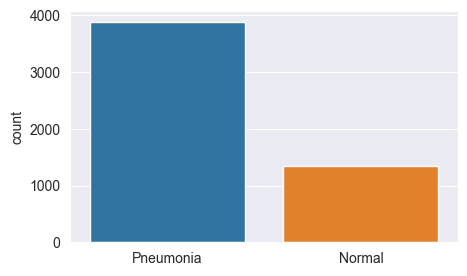

In [8]:
n = []
for i in os.listdir(pneumonia_train_dir):
    n.append("Pneumonia")
for j in os.listdir(normal_train_dir):
    n.append("Normal")

plt.figure(figsize=(5, 3))
sns.set_style('darkgrid')
sns.countplot(x=n, hue=n)
plt.show()

The training dataset is imbalanced. We need data augmentation technique to increase the number of training examples.

#### Load the Dataset

In [9]:
def load_images(dir):
    image_list = os.listdir(dir)
    images = []
    
    # load the first 20 images
    for image_name in image_list[:20]:
        img = Image.open(os.path.join(dir, image_name))
        if img is not None:
            images.append(img)
    return images

In [10]:
def display_images(images):
    # create figure
    fig= plt.figure(figsize=(20, 5))
    
    # setting values to rows and column variables
    rows = 2
    columns = 10
    for i,img in enumerate(images):
        fig.add_subplot(rows,columns,i+1)
        plt.imshow(img, cmap='gray')
        fig.tight_layout()
    plt.show()
    return None

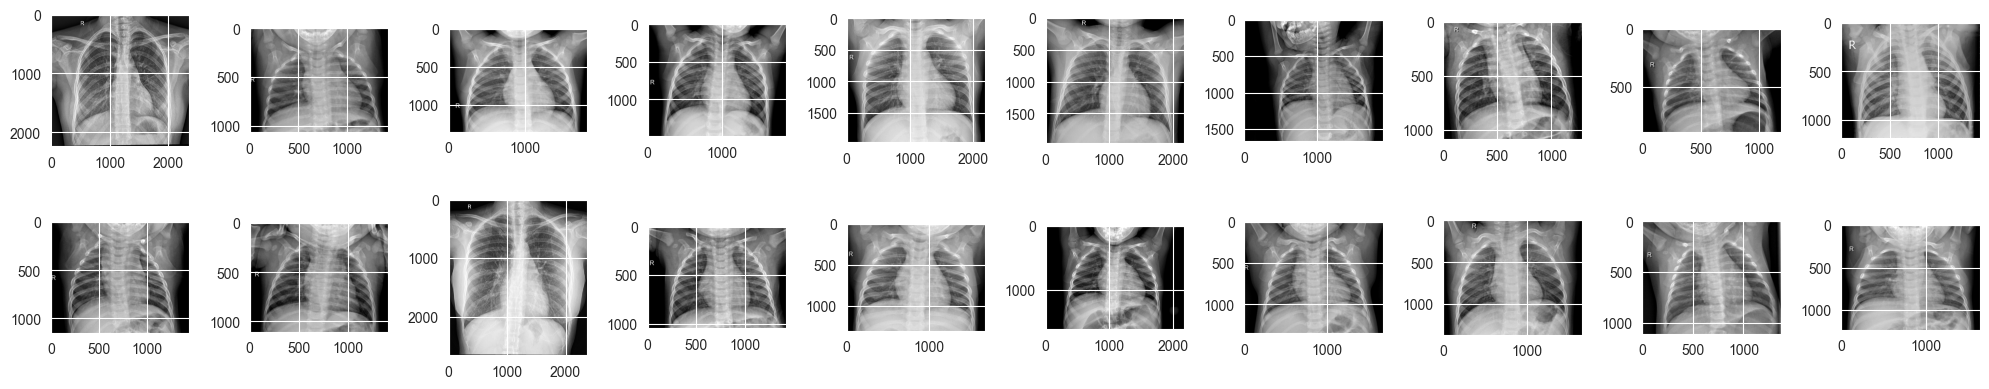

In [11]:
normal_images = load_images(normal_train_dir)
display_images(normal_images)

Above displays 20 examples of normal training images.

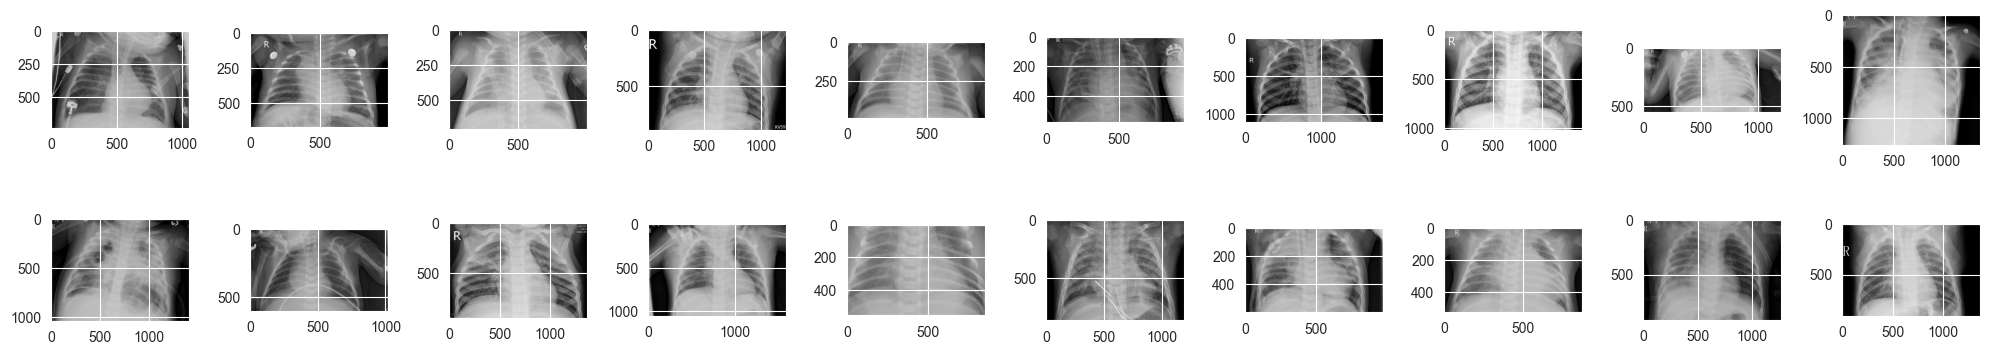

In [12]:
pneumonia_images = load_images(pneumonia_train_dir)
display_images(pneumonia_images)

Above displays 20 examples of pneumonia training images.

In [13]:
os.listdir(train_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [14]:
# Create custom dataset class to load images
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d)))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Preprocessing - Data Augmentation

In [15]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training transforms WITH augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms - NO augmentation, same as before
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Create DataLoaders

In [16]:
train_dataset = ChestXrayDataset(
    data_dir = train_dir,
    transform = train_transforms
)

val_dataset = ChestXrayDataset(
    data_dir = val_dir,
    transform = val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## MobileNetV2 Transfer Learning

In [17]:
class PneumoniaDetectionMobileNet(nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoniaDetectionMobileNet, self).__init__()
        
        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Remove original classifier
        self.base_model.classifier = nn.Identity()
        
        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

#### Train the model

In [18]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over the training data
        for inputs, labels in train_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
    
            # Zero the parameter gradients to prevent accumulation
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze(1)     # (B,)
            labels = labels.float()          # 0. or 1.
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_loss += loss.item()
            # Get predictions
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()
            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
    
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Disable gradient calculation for validation
        with torch.no_grad():
            # Iterate over the validation data
            for inputs, labels in val_loader:
                # Move data to the specified device (GPU or CPU)
                inputs, labels = inputs.to(device), labels.to(device)
                # Forward pass
                outputs = model(inputs)
                # Calculate the loss
                outputs = outputs.squeeze(1)     # (B,)
                labels = labels.float()          # 0. or 1.
                loss = criterion(outputs, labels)
    
                # Accumulate validation loss
                val_loss += loss.item()
                # Get predictions
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).long()
                # Update total and correct predictions
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
    
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Checkpoint the model if validation accuracy improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            dir = 'model'
            checkpoint = f'mobilenet_v2_{epoch+1:02d}_{val_acc:.3f}.pth'
            checkpoint_path = os.path.join(dir, checkpoint)
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PneumoniaDetectionMobileNet(num_classes=1)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 5

In [29]:
train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/5
  Train Loss: 0.2413, Train Acc: 0.8984
  Val Loss: 0.5116, Val Acc: 0.7500
Checkpoint saved: model/mobilenet_v2_01_0.750.pth
Epoch 2/5
  Train Loss: 0.1646, Train Acc: 0.9358
  Val Loss: 0.3424, Val Acc: 0.8750
Checkpoint saved: model/mobilenet_v2_02_0.875.pth
Epoch 3/5
  Train Loss: 0.1653, Train Acc: 0.9377
  Val Loss: 0.1829, Val Acc: 0.8750
Epoch 4/5
  Train Loss: 0.1594, Train Acc: 0.9419
  Val Loss: 0.3558, Val Acc: 0.8125
Epoch 5/5
  Train Loss: 0.2963, Train Acc: 0.9118
  Val Loss: 0.3559, Val Acc: 0.8750


## Fine Tuning The Model

#### Learning Rate

The learning rate controls how much to update model weights during training.

- Too fast: Skip details, poor understanding (may not converge)
- Too slow: Never finish the book (training takes too long)
- Just right: Good comprehension and efficiency

Experimentation approach: 

Try multiple values: [0.0001, 0.001, 0.01, 0.1]

In [30]:
def make_model(learning_rate=0.01):
    model = PneumoniaDetectionMobileNet(num_classes=1)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [31]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
num_epochs = 3

for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')
    model, optimizer = make_model(learning_rate=lr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Learning Rate: 0.0001 ===
Epoch 1/3
  Train Loss: 0.5183, Train Acc: 0.7421
  Val Loss: 0.5810, Val Acc: 0.5000
Checkpoint saved: model/mobilenet_v2_01_0.500.pth
Epoch 2/3
  Train Loss: 0.3757, Train Acc: 0.8363
  Val Loss: 0.5082, Val Acc: 0.6250
Checkpoint saved: model/mobilenet_v2_02_0.625.pth
Epoch 3/3
  Train Loss: 0.3070, Train Acc: 0.8842
  Val Loss: 0.4466, Val Acc: 0.8750
Checkpoint saved: model/mobilenet_v2_03_0.875.pth

=== Learning Rate: 0.001 ===
Epoch 1/3
  Train Loss: 0.2870, Train Acc: 0.8788
  Val Loss: 0.4477, Val Acc: 0.7500
Checkpoint saved: model/mobilenet_v2_01_0.750.pth
Epoch 2/3
  Train Loss: 0.1759, Train Acc: 0.9321
  Val Loss: 0.3214, Val Acc: 0.8125
Checkpoint saved: model/mobilenet_v2_02_0.812.pth
Epoch 3/3
  Train Loss: 0.1572, Train Acc: 0.9377
  Val Loss: 0.4295, Val Acc: 0.7500

=== Learning Rate: 0.01 ===
Epoch 1/3
  Train Loss: 0.2400, Train Acc: 0.9028
  Val Loss: 0.3010, Val Acc: 0.8750
Checkpoint saved: model/mobilenet_v2_01_0.875.pth
Epoch 2/

Among different values of learning rate, 0.001 stands out with the most smooth convergence and stability, while the rest shows validation instability.

#### Dropout Regularization

Dropout randomly drops neurons during training to prevent overfitting. It prevents relying on specific features by learning robust patterns.

How it works:

- Training: randomly set fraction of activations to 0
- Inference: use all neurons (dropout disabled automatically)
- Creates ensemble effect

Experimentation:

- Try: droprate = [0.0, 0.2, 0.5, 0.8]
- Typical values: 0.2 to 0.5
- Higher dropout may need more training epochs

In [20]:
class PneumoniaDetectionMobileNet(nn.Module):
    def __init__(self, droprate=0.2, num_classes=1):
        super(PneumoniaDetectionMobileNet, self).__init__()
        
        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

In [21]:
def make_model(learning_rate=0.001, droprate=0.2):
    model = PneumoniaDetectionMobileNet(num_classes=1, droprate=droprate)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [22]:
drop_rates = [0.0, 0.2, 0.5, 0.8]
num_epochs = 3

for dr in drop_rates:
    print(f'\n=== Drop Rate: {dr} ===')
    model, optimizer = make_model(learning_rate=0.001, droprate=dr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Drop Rate: 0.0 ===
Epoch 1/3
  Train Loss: 0.2708, Train Acc: 0.8930
  Val Loss: 0.3905, Val Acc: 0.7500
Checkpoint saved: model/mobilenet_v2_01_0.750.pth
Epoch 2/3
  Train Loss: 0.1713, Train Acc: 0.9373
  Val Loss: 0.3297, Val Acc: 0.8125
Checkpoint saved: model/mobilenet_v2_02_0.812.pth
Epoch 3/3
  Train Loss: 0.1535, Train Acc: 0.9411
  Val Loss: 0.4327, Val Acc: 0.7500

=== Drop Rate: 0.2 ===
Epoch 1/3
  Train Loss: 0.2878, Train Acc: 0.8836
  Val Loss: 0.4555, Val Acc: 0.6875
Checkpoint saved: model/mobilenet_v2_01_0.688.pth
Epoch 2/3
  Train Loss: 0.1824, Train Acc: 0.9289
  Val Loss: 0.3358, Val Acc: 0.8750
Checkpoint saved: model/mobilenet_v2_02_0.875.pth
Epoch 3/3
  Train Loss: 0.1618, Train Acc: 0.9371
  Val Loss: 0.2975, Val Acc: 0.8750

=== Drop Rate: 0.5 ===
Epoch 1/3
  Train Loss: 0.3153, Train Acc: 0.8708
  Val Loss: 0.4178, Val Acc: 0.6875
Checkpoint saved: model/mobilenet_v2_01_0.688.pth
Epoch 2/3
  Train Loss: 0.2018, Train Acc: 0.9195
  Val Loss: 0.3640, Val Ac

Drop rate 0.2 shows the best overall with strong training and validation accuracy scores and stable loss decrease.

## Evaluation

Accuracy and loss values will be manually entered to generate plots as I have not included in the training function and it takes significant amount of time to re-train.

#### Model without Fine-Tuning

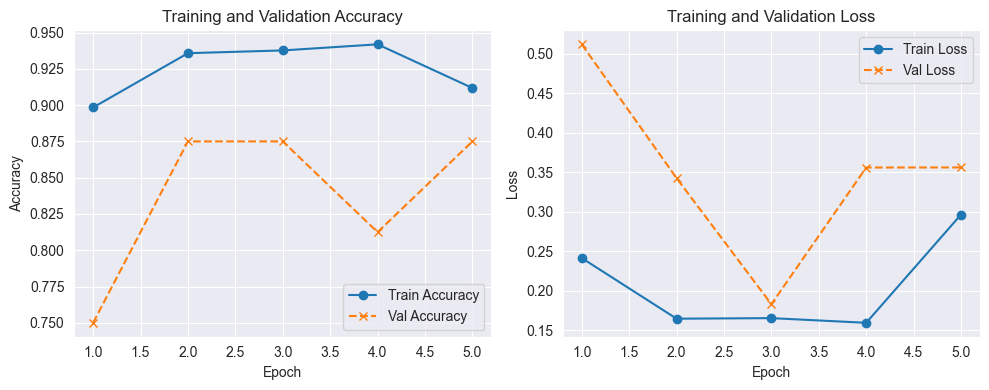

In [23]:
epochs = [1, 2, 3, 4, 5]

history = {
        "train_loss": [0.2413, 0.1646, 0.1653, 0.1594, 0.2963],
        "val_loss":   [0.5116, 0.3424, 0.1829, 0.3558, 0.3559],
        "train_acc":  [0.8984, 0.9358, 0.9377, 0.9419, 0.9118],
        "val_acc":    [0.7500, 0.8750, 0.8750, 0.8125, 0.8750],
        }
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ---- Accuracy plot ----
axes[0].plot(epochs, history["train_acc"], marker="o", label="Train Accuracy")
axes[0].plot(epochs, history["val_acc"], marker="x", linestyle="--", label="Val Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training and Validation Accuracy")
axes[0].legend()
axes[0].grid(True)

# ---- Loss plot ----
axes[1].plot(epochs, history["train_loss"], marker="o", label="Train Loss")
axes[1].plot(epochs, history["val_loss"], marker="x", linestyle="--", label="Val Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training and Validation Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Fine-Tuning Learning Rate

In [24]:
epochs = [1, 2, 3]

histories = {
    "LR = 0.0001": {
        "train_loss": [0.5183, 0.3757, 0.3070],
        "val_loss":   [0.5810, 0.5082, 0.4466],
        "train_acc":  [0.7421, 0.8363, 0.8842],
        "val_acc":    [0.5000, 0.6250, 0.8750],
    },
    "LR = 0.001": {
        "train_loss": [0.2870, 0.1759, 0.1572],
        "val_loss":   [0.4477, 0.3214, 0.4295],
        "train_acc":  [0.8788, 0.9321, 0.9377],
        "val_acc":    [0.7500, 0.8125, 0.7500],
    },
    "LR = 0.01": {
        "train_loss": [0.2400, 0.1810, 0.2007],
        "val_loss":   [0.3010, 1.0604, 0.5848],
        "train_acc":  [0.9028, 0.9317, 0.9304],
        "val_acc":    [0.8750, 0.6875, 0.8750],
    },
    "LR = 0.1": {
        "train_loss": [1.6023, 0.8757, 0.7752],
        "val_loss":   [5.1402, 6.0550, 0.5392],
        "train_acc":  [0.9005, 0.9147, 0.9321],
        "val_acc":    [0.5000, 0.5000, 0.8750],
    }
}

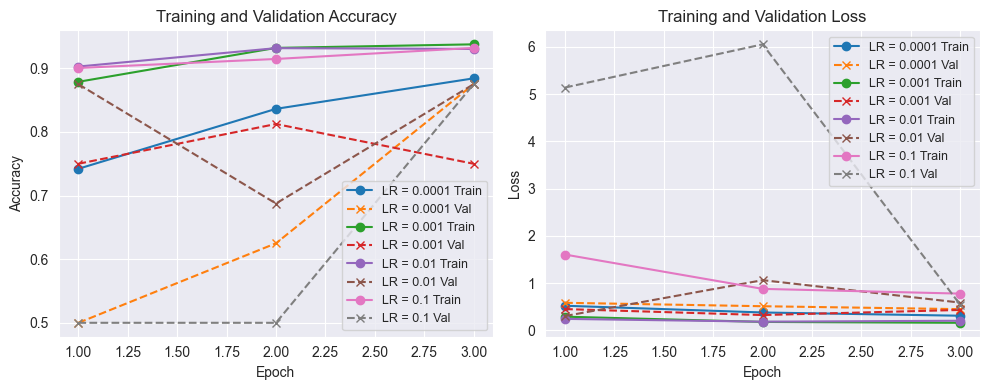

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ---- ACCURACY PLOT ----
for lr, data in histories.items():
    axes[0].plot(epochs, data["train_acc"], marker="o", label=f"{lr} Train")
    axes[0].plot(epochs, data["val_acc"], marker="x", linestyle="--", label=f"{lr} Val")

axes[0].set_title("Training and Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend(fontsize=9)

# ---- LOSS PLOT ----
for lr, data in histories.items():
    axes[1].plot(epochs, data["train_loss"], marker="o", label=f"{lr} Train")
    axes[1].plot(epochs, data["val_loss"], marker="x", linestyle="--", label=f"{lr} Val")

axes[1].set_title("Training and Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

#### Fine-Tuning Drop Rate

In [26]:
epochs = [1, 2, 3]

histories = {
    "Drop 0.0": {
        "train_loss": [0.2708, 0.1713, 0.1535],
        "val_loss":   [0.3905, 0.3297, 0.4327],
        "train_acc":  [0.8930, 0.9373, 0.9411],
        "val_acc":    [0.7500, 0.8125, 0.7500],
    },
    "Drop 0.2": {
        "train_loss": [0.2878, 0.1824, 0.1618],
        "val_loss":   [0.4555, 0.3358, 0.2975],
        "train_acc":  [0.8836, 0.9289, 0.9371],
        "val_acc":    [0.6875, 0.8750, 0.8750],
    },
    "Drop 0.5": {
        "train_loss": [0.3153, 0.2018, 0.1818],
        "val_loss":   [0.4178, 0.3640, 0.2758],
        "train_acc":  [0.8708, 0.9195, 0.9275],
        "val_acc":    [0.6875, 0.8125, 0.8750],
    },
    "Drop 0.8": {
        "train_loss": [0.3698, 0.2680, 0.2456],
        "val_loss":   [0.4211, 0.3677, 0.3346],
        "train_acc":  [0.8345, 0.8848, 0.8953],
        "val_acc":    [0.7500, 0.7500, 0.8125],
    }
}

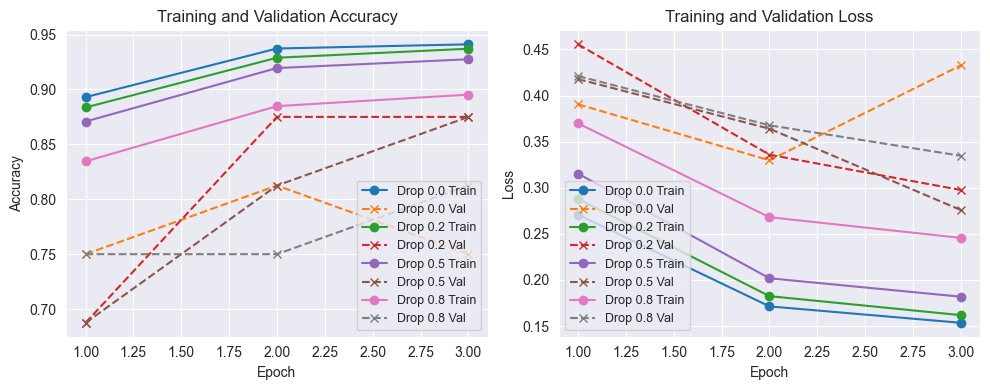

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ---- ACCURACY ----
for drop, data in histories.items():
    axes[0].plot(epochs, data["train_acc"], marker="o", label=f"{drop} Train")
    axes[0].plot(epochs, data["val_acc"], marker="x", linestyle="--", label=f"{drop} Val")

axes[0].set_title("Training and Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend(fontsize=9)

# ---- LOSS ----
for drop, data in histories.items():
    axes[1].plot(epochs, data["train_loss"], marker="o", label=f"{drop} Train")
    axes[1].plot(epochs, data["val_loss"], marker="x", linestyle="--", label=f"{drop} Val")

axes[1].set_title("Training and Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()